In this notebook I demonstrate my SQL approach to different questions about the video game data. The cleaning process before this can be found [here](https://github.com/phucnguyen233/Portfolio/blob/master/SQL%20Showcase/Video%20Games/data_check_and_clean.ipynb).

* * *

Since this database was created from a single data table scrapped from an online website, I like to `JOIN` all tables into a single one for convenience. 

I choose to create a `temporary table` instead of permanent one because I will query from this table mulitple times and it will automatically be dropped once the the connection to the database ends. Temporary tables in SQL Server have `#` at the beginning.

In [1]:
-- Create temporary table
SELECT
    g.game_name,
    gr.genre_name,
    pb.publisher_name,
    pf.platform_name,
    gpf.release_year,
    r.region_name,
    rs.num_sales
INTO #summary_temptbl
FROM game g 
RIGHT JOIN genre gr ON g.genre_id = gr.genre_id
JOIN game_publisher gpb ON g.game_id = gpb.game_id
RIGHT JOIN publisher pb ON gpb.publisher_id = pb.publisher_id
JOIN game_platform gpf ON gpb.game_publisher_id = gpf.game_publisher_id
RIGHT JOIN platform pf on gpf.platform_id = pf.platform_id
JOIN region_sales rs ON gpf.game_platform_id = rs.game_platform_id
RIGHT JOIN region r ON rs.region_id = r.region_id

-- Quick view at the temp table
SELECT TOP 10 *
FROM #summary_temptbl

(65304 rows affected)

(10 rows affected)

Total execution time: 00:00:01.374

game_name,genre_name,publisher_name,platform_name,release_year,region_name,num_sales
Mountain Sports,Sports,Activision,Wii,2009,North America,0.110
Pimp My Ride,Racing,Activision,Wii,2008,North America,0.100
The History Channel: Battle for the Pacific,Shooter,Activision,Wii,2007,North America,0.100
Animal Planet: Vet Life,Simulation,Activision,Wii,2009,North America,0.090
Big League Sports: Summer,Sports,Activision,Wii,2009,North America,0.090
Spider-Man 2,Action,Activision,DS,2004,North America,0.410
Kung Fu Panda,Action,Activision,DS,2008,North America,0.560
GoldenEye 007 (2010),Action,Activision,DS,2010,North America,0.110
Moshi Monsters: Moshling Zoo,Misc,Activision,DS,2011,North America,0.400
iCarly,Adventure,Activision,DS,2009,North America,0.670


This simple query returns the number of instances in each column:

In [24]:
SELECT
    COUNT(distinct game_name) games,
    COUNT(distinct genre_name) genres,
    COUNT(distinct publisher_name) publishers,
    COUNT(distinct platform_name) platforms,
    COUNT(distinct region_name) regions
FROM #summary_temptbl

(1 row affected)

Total execution time: 00:00:00.848

games,genres,publishers,platforms,regions
11356,12,577,31,4


I like to know the distribution of game released throught the years. From the result, the first video game made was in 1980. Game titles passed 100 in 1991 and 1000 five years later. From there the number of games released peaked at over 5700 titles during the Great Recession (2008 - 2009). Since then games count decreased to around 1400 in 2016

In [ ]:
SELECT
    release_year,
    COUNT(release_year) as games
FROM #summary_temptbl
GROUP BY release_year
ORDER BY 1

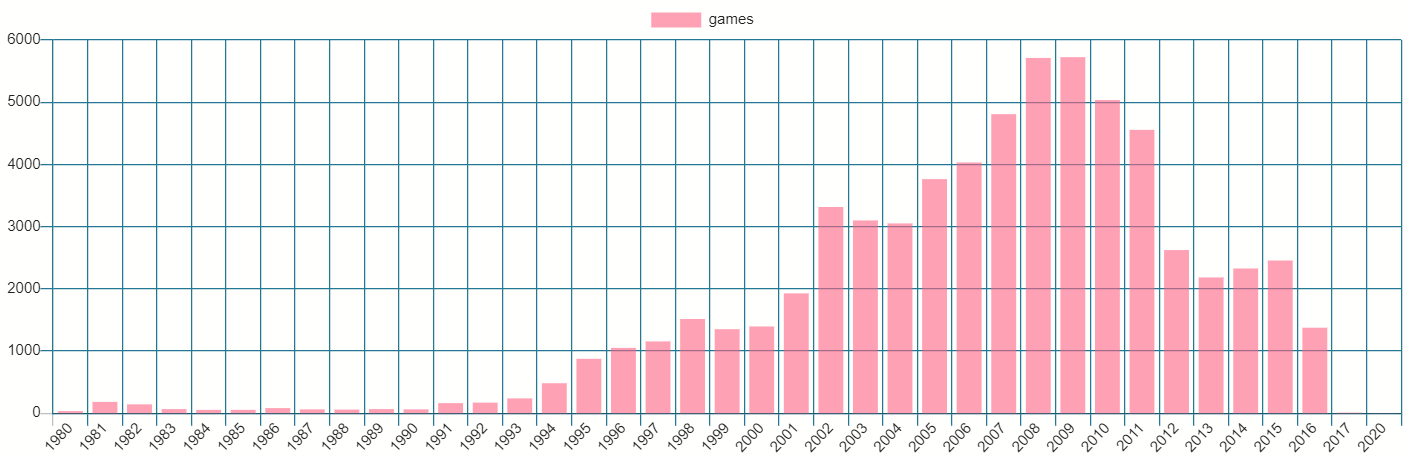  

As you can see, there is very few titles for 2017 and 2020, so I will remove these rows from the table because it doesn't reflect accurate values

In [ ]:
DELETE FROM #summary_temptbl
WHERE release_year > 2016

I also want to know the distribution of sales:

In [ ]:
SELECT
    num_sales as sales_in_mil,
    COUNT(num_sales) as [count]
FROM #summary_temptbl
GROUP BY num_sales 
ORDER BY 1

It will be hard to see the histogram with all values so I split to 2 views. The first one is sales at 1 million and lower:

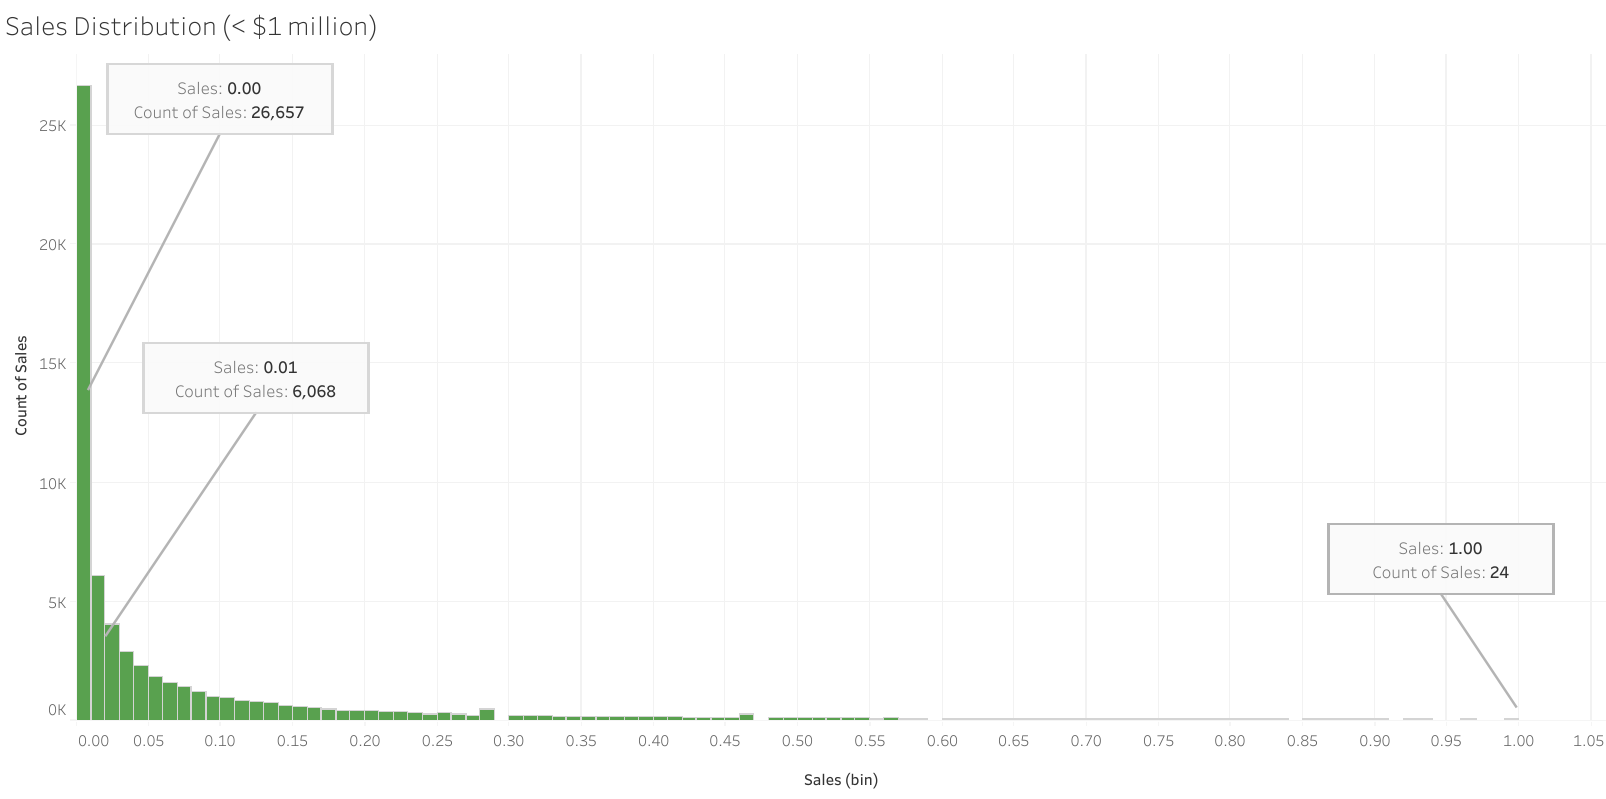

There are over 26,000 values of \$0 in sales number. It could be that these games' sales were below \$10,000, or there are no statistics for sales (N/A values). I decide to turn those 0s into `NULL` because they will greatly decrease average or median values if not left out.

In [ ]:
UPDATE #summary_temptbl 
SET num_sales = NULL 
WHERE num_sales = 0

The second histogram view is salse above $1 million:

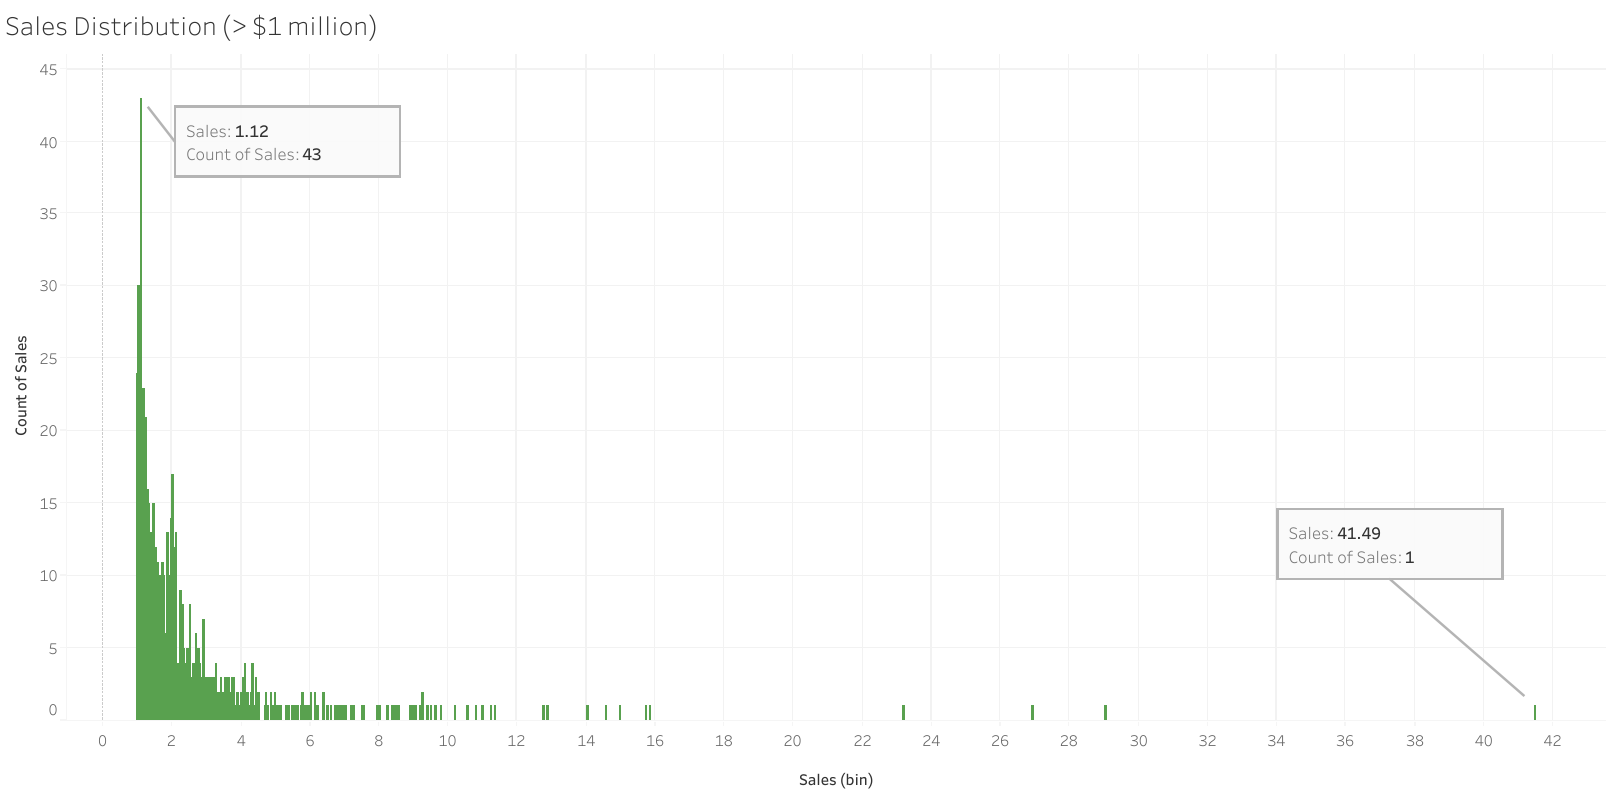

$1.12 million in sales is the mode for this view with 43 values. In general, sales distribution for video games is heavily right-skewed with extreme values spread far on the right tail. Please note that _**this is snapshot of cummulative sales collected at a point in time**_, not yearly sales, so yearly figures might have a different distribution shape.

Next, I want to know the exact quartile values, along with average, min and max of the whole data:

In [9]:
SELECT DISTINCT
    AVG(num_sales) OVER () as AVG_sales,
    MIN(num_sales) OVER () as min_sales,
    PERCENTILE_DISC(0.25) WITHIN GROUP (ORDER BY num_sales) OVER () Q1_sales,
    PERCENTILE_DISC(0.5) WITHIN GROUP (ORDER BY num_sales) OVER () median_sales,
    PERCENTILE_DISC(0.75) WITHIN GROUP (ORDER BY num_sales) OVER () Q3_sales,
    MAX(num_sales) OVER () as max_sales
FROM #summary_temptbl

Warning: Null value is eliminated by an aggregate or other SET operation.

(1 row affected)

Total execution time: 00:00:01.085

AVG_sales,min_sales,Q1_sales,median_sales,Q3_sales,max_sales
0.228231,0.010,0.020,0.070,0.200,41.490


You can tell that the average sales was a lot higher than median sales because of right-skewed distribution. It is even higher than the third quartile (75% of values). The max sales was close to $41.5 millions, an incredible number for a title on a single platform.

Below I broke down the boxplot to region level. First I wrote a query to return boxplot table by region, and then I visualized it into a chart. I added the `PARTITION BY` part in the `OVER` clause to return the correct numbers by region groupings:

In [11]:
SELECT DISTINCT
    region_name, 
    AVG(num_sales) OVER (PARTITION BY region_name) as AVG_sales,
    MIN(num_sales) OVER (PARTITION BY region_name) as min_sales,
    PERCENTILE_DISC(0.25) WITHIN GROUP (ORDER BY num_sales) OVER (PARTITION BY region_name) Q1_sales,
    PERCENTILE_DISC(0.5) WITHIN GROUP (ORDER BY num_sales) OVER (PARTITION BY region_name) median_sales,
    PERCENTILE_DISC(0.75) WITHIN GROUP (ORDER BY num_sales) OVER (PARTITION BY region_name) Q3_sales,
    MAX(num_sales) OVER (PARTITION BY region_name) as max_sales
FROM #summary_temptbl
ORDER BY AVG_sales DESC

Warning: Null value is eliminated by an aggregate or other SET operation.

(4 rows affected)

Total execution time: 00:00:00.778

region_name,AVG_sales,min_sales,Q1_sales,median_sales,Q3_sales,max_sales
North America,0.364532,0.010,0.060,0.140,0.350,41.490
Europe,0.225267,0.010,0.020,0.070,0.200,29.020
Japan,0.211122,0.010,0.030,0.070,0.190,10.220
Other,0.079207,0.010,0.010,0.030,0.070,10.570


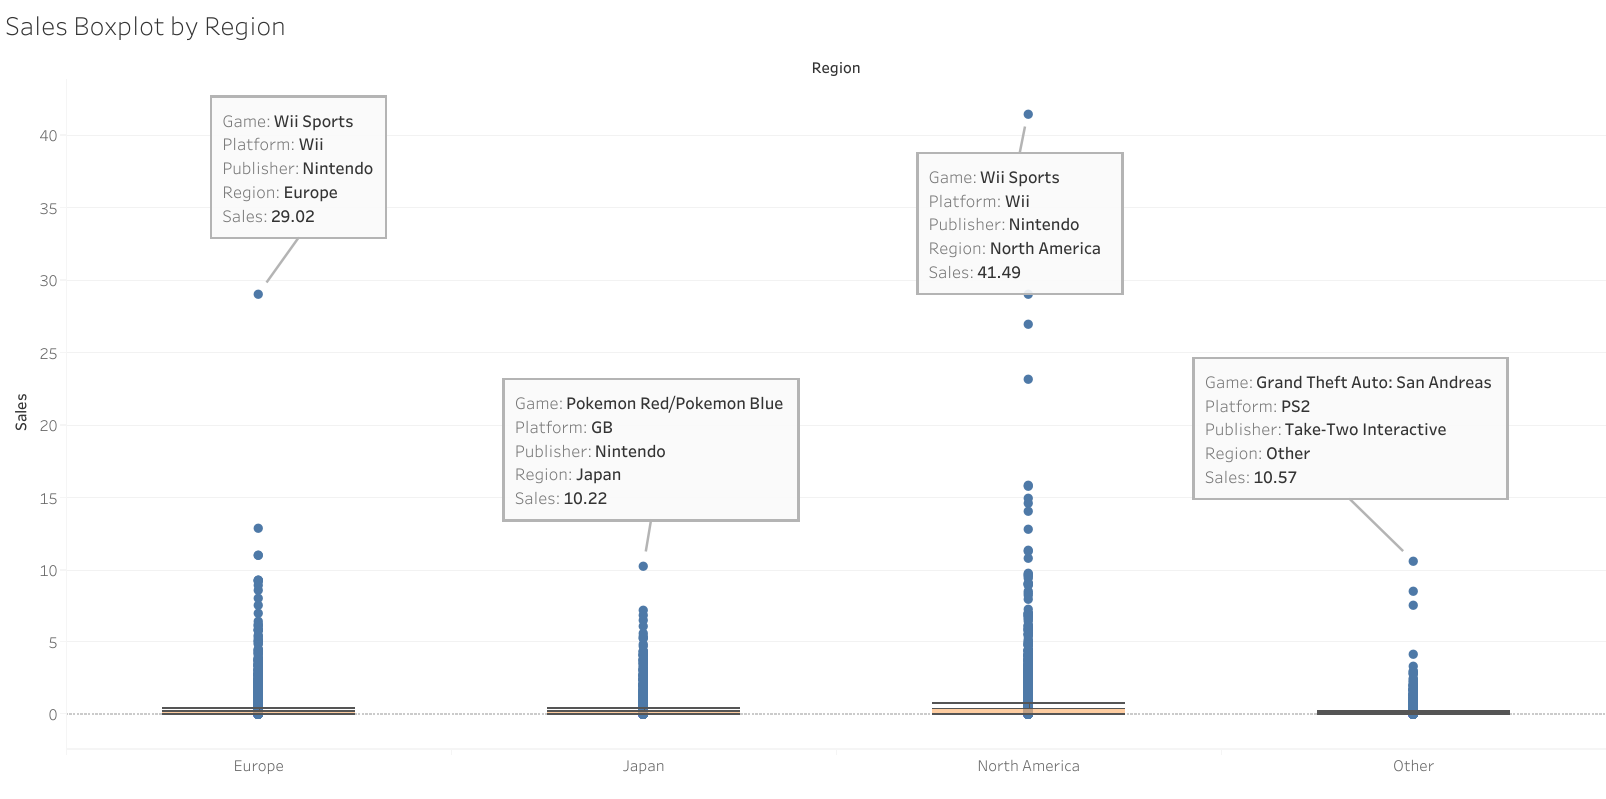

**Wii Sports** from Nintendo dominates NA and EU markets in terms of cummulative sales. Another title from this publisher has highest sales in Japan. The outliers are too extreme that it's hard to see interquartile ranges so I will filter most of them out in the below chart. NA region has higher range and wider range, with the upper whisker at $0.6 million. EU and Japan have nearly the same range.

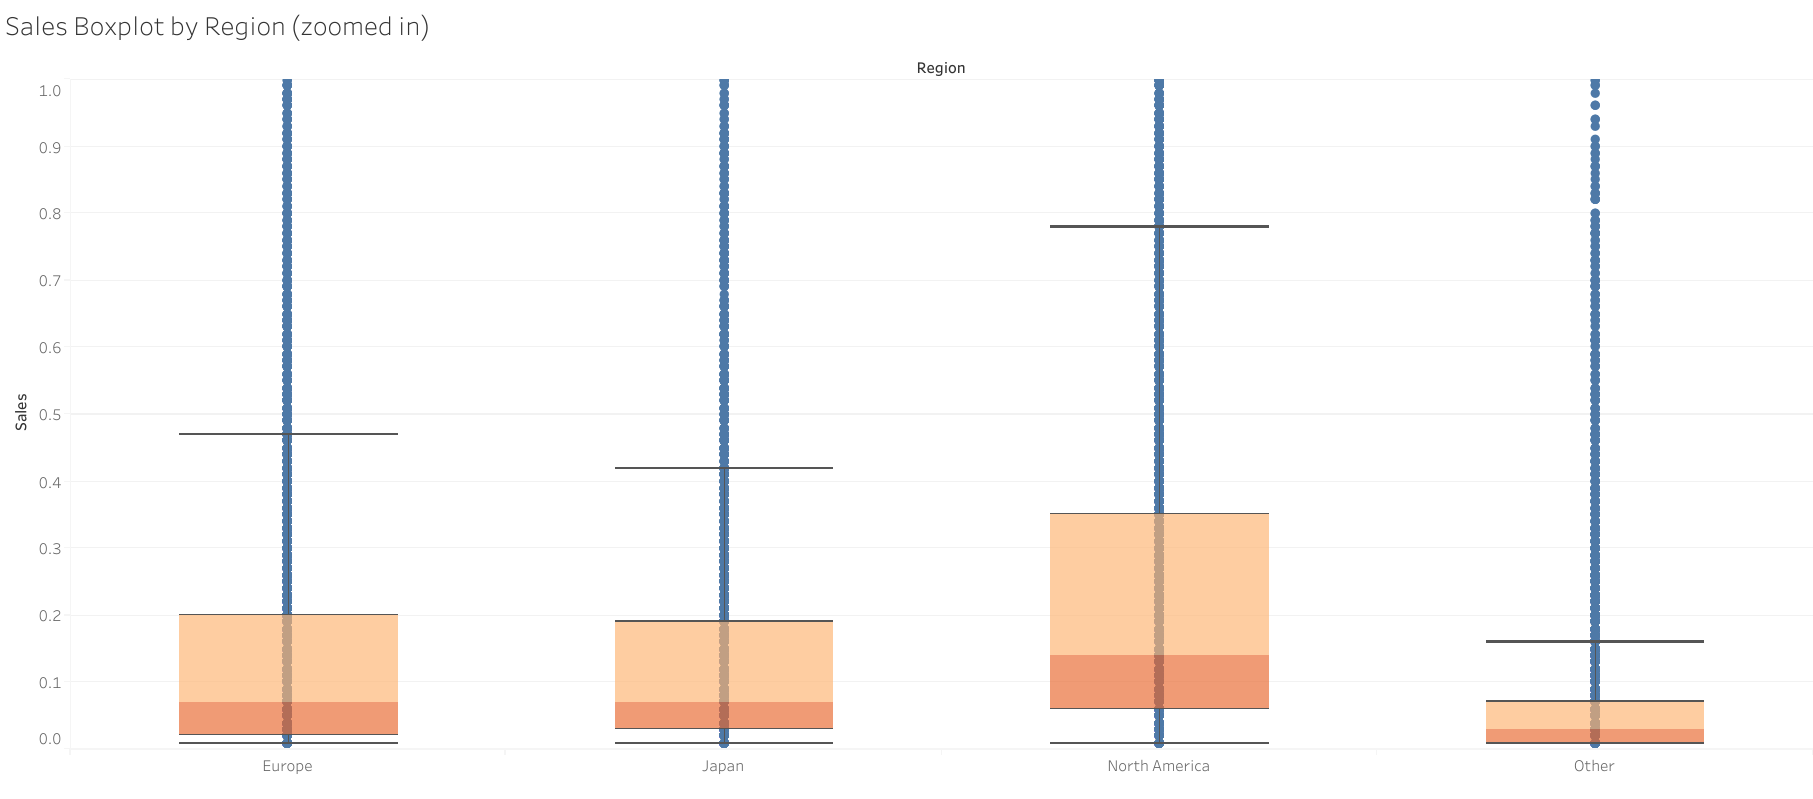

In the query below, I group sales numbers into 4 buckets to spot the proportion of different ranges easily. The chart shows that almost 60% of titles have revenues less than \$100000, and about 4% of games reached \$1 million and more in sales.

In [4]:
SELECT
    sales_range,
    COUNT(*) AS games,
    cast(COUNT(*)*100 AS decimal(10,3)) / SUM(COUNT(*)) OVER () AS pct
FROM
(
    SELECT
    CASE
        WHEN num_sales < 0.1 then 'less than \$100K'
        WHEN num_sales < 0.5 THEN '\$100K - less than \$500K'
        WHEN num_sales < 1 THEN '\$500K - less than \$1MIL'
        WHEN num_sales < 10 THEN '\$1MIL - less than \$10MIL'
        ELSE '\$10MIL and higher' END AS sales_range
FROM #summary_temptbl
WHERE num_sales IS NOT NULL
) a
GROUP BY sales_range
ORDER BY 2 DESC

(5 rows affected)

Total execution time: 00:00:00.102

sales_range,games,pct
less than \$100K,22369,57.90427376977039
\$100K - less than \$500K,12297,31.83194843519453
\$500K - less than \$1MIL,2274,5.88646423856488
\$1MIL - less than \$10MIL,1672,4.32813025808288
\$10MIL and higher,19,0.04918329838730


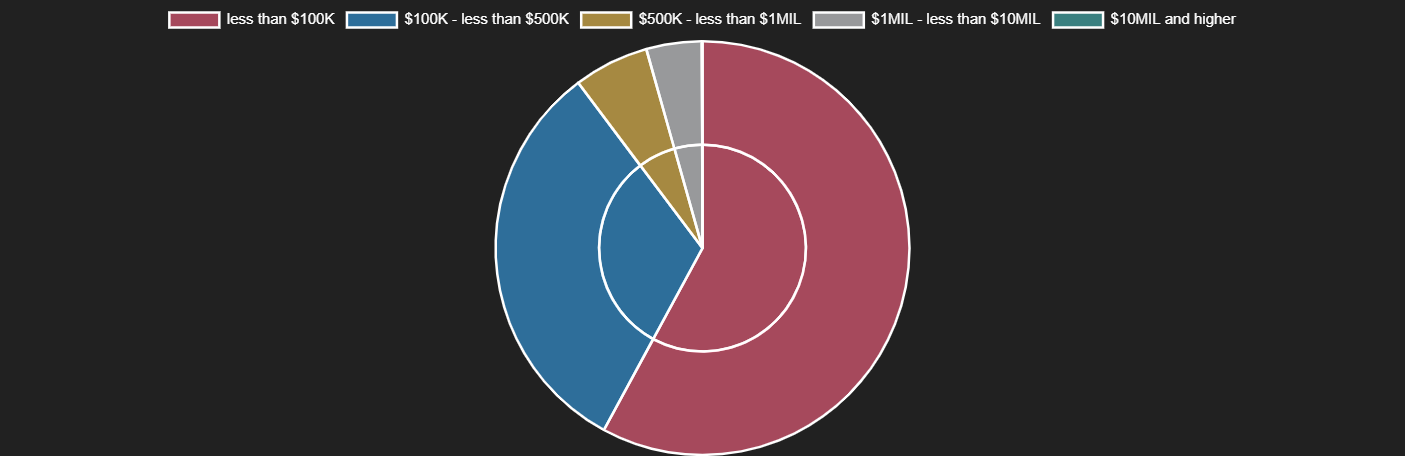

In case I want to do some analysis with this sales buckets, I add a column to the temporary table with `ALTER TABLE ADD column` clause. This type of column is computed column because it derives values from base columns. The `PERSISTED` keyword tells SQL to store the data physically on disk instead of recomputing.

> `PERSISTED` can only be enforced when the expression in the computed column is deterministic. It means that for a set of inputs, the expression always returns the same result.

In [ ]:
ALTER TABLE #summary_temptbl
ADD sales_range AS CASE
    WHEN num_sales is null then 'N/A'
    WHEN num_sales < 0.1 then 'less than $100K'
    WHEN num_sales < 0.5 THEN '$100K - less than $500K'
    WHEN num_sales < 1 THEN '$500K - less than $1MIL'
    WHEN num_sales < 10 THEN '$1MIL - less than $10MIL'
    ELSE '$10MIL and higher' END PERSISTED

Total cummulative sales by year shows a similar distribution like total game titles by year, with a peak in 2008 and 2009.



In [ ]:
SELECT
    release_year,
    SUM(num_sales) as total_sales
from #summary_temptbl
GROUP BY release_year
ORDER BY 1

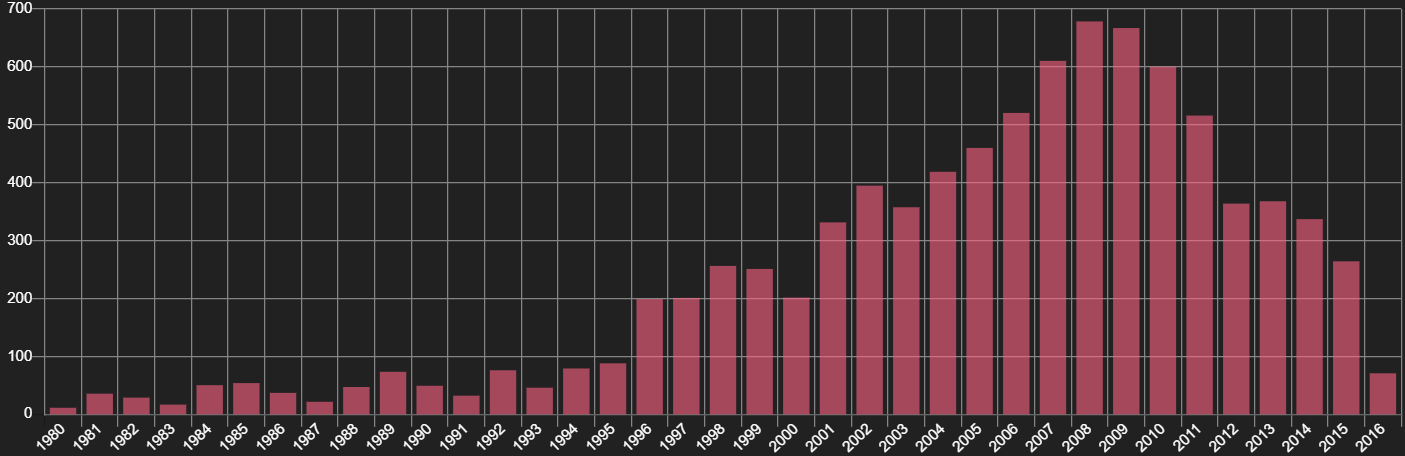

This query also return sales by year but down to region level to see how different areas compare with one another. I add the `PIVOT` clause for report-like view and easy charting on Azure Data Studio.

In [33]:
SELECT * FROM
(
    SELECT
        release_year,
        region_name,
        num_sales as total_sales
    from #summary_temptbl
) a
PIVOT (
    sum(total_sales)
    FOR region_name IN (
        [North America],
        [Europe],
        [Japan],
        [Other]
    )
) AS pivot_tbl
ORDER BY 1 

(37 rows affected)

Total execution time: 00:00:02.476

release_year,North America,Europe,Japan,Other
1980,10.590,0.670,NULL,0.120
1981,33.400,1.960,NULL,0.320
1982,26.920,1.650,NULL,0.310
1983,7.760,0.800,8.100,0.140
1984,33.280,2.100,14.270,0.700
1985,33.730,4.740,14.560,0.920
1986,12.500,2.840,19.810,1.930
1987,8.460,1.410,11.630,0.200
1988,23.870,6.590,15.760,0.990
1989,45.150,8.440,18.360,1.500


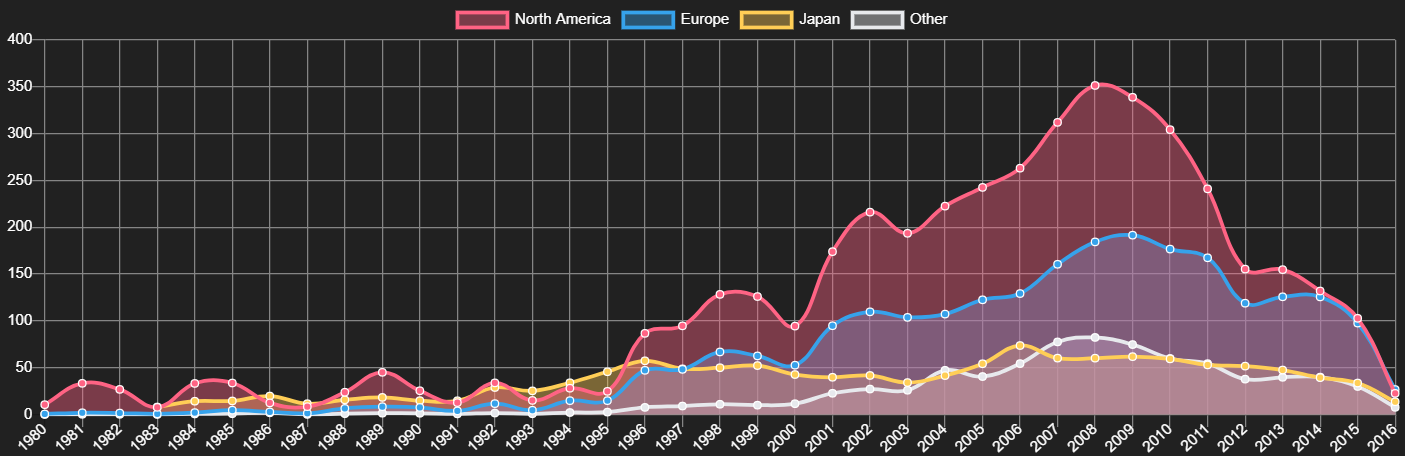 

Before 1995 there was not much difference between regions, but since then Japan sales was exceeded by NA sales and after 2000 by EU sales. Sales in Japan moved around $50 millions line for a long time, while other 2 big regions saw dramatic sales increase up until 2008 - 2009.

I continue to inspect the sales by game genres: **Action** brings the most sales with $1.7 billion, **Sports** ranks second and **Shooter** third, both above $1 billion

In [6]:
SELECT
    genre_name,
    SUM(num_sales) total_sales
FROM #summary_temptbl
GROUP BY genre_name
ORDER BY 2 DESC

Warning: Null value is eliminated by an aggregate or other SET operation.

(12 rows affected)

Total execution time: 00:00:03.404

genre_name,total_sales
Action,1722.040
Sports,1308.830
Shooter,1025.750
Role-Playing,923.710
Platform,828.820
Misc,796.830
Racing,727.830
Fighting,444.080
Simulation,389.590
Puzzle,241.690


I'm curious about how Action and Sports genre competes in terms of sales throughout the years, so write a query to calculate percentage difference of Action over Sports. I also make a chart so you can see the difference clearly:

In [ ]:
SELECT
    release_year,
    (SUM(CASE WHEN genre_name = 'Action' THEN num_sales END) /
    SUM(CASE WHEN genre_name = 'Sports' THEN num_sales END) - 1)*100 AS action_sport_ratio
FROM #summary_temptbl
GROUP BY release_year
ORDER BY 1


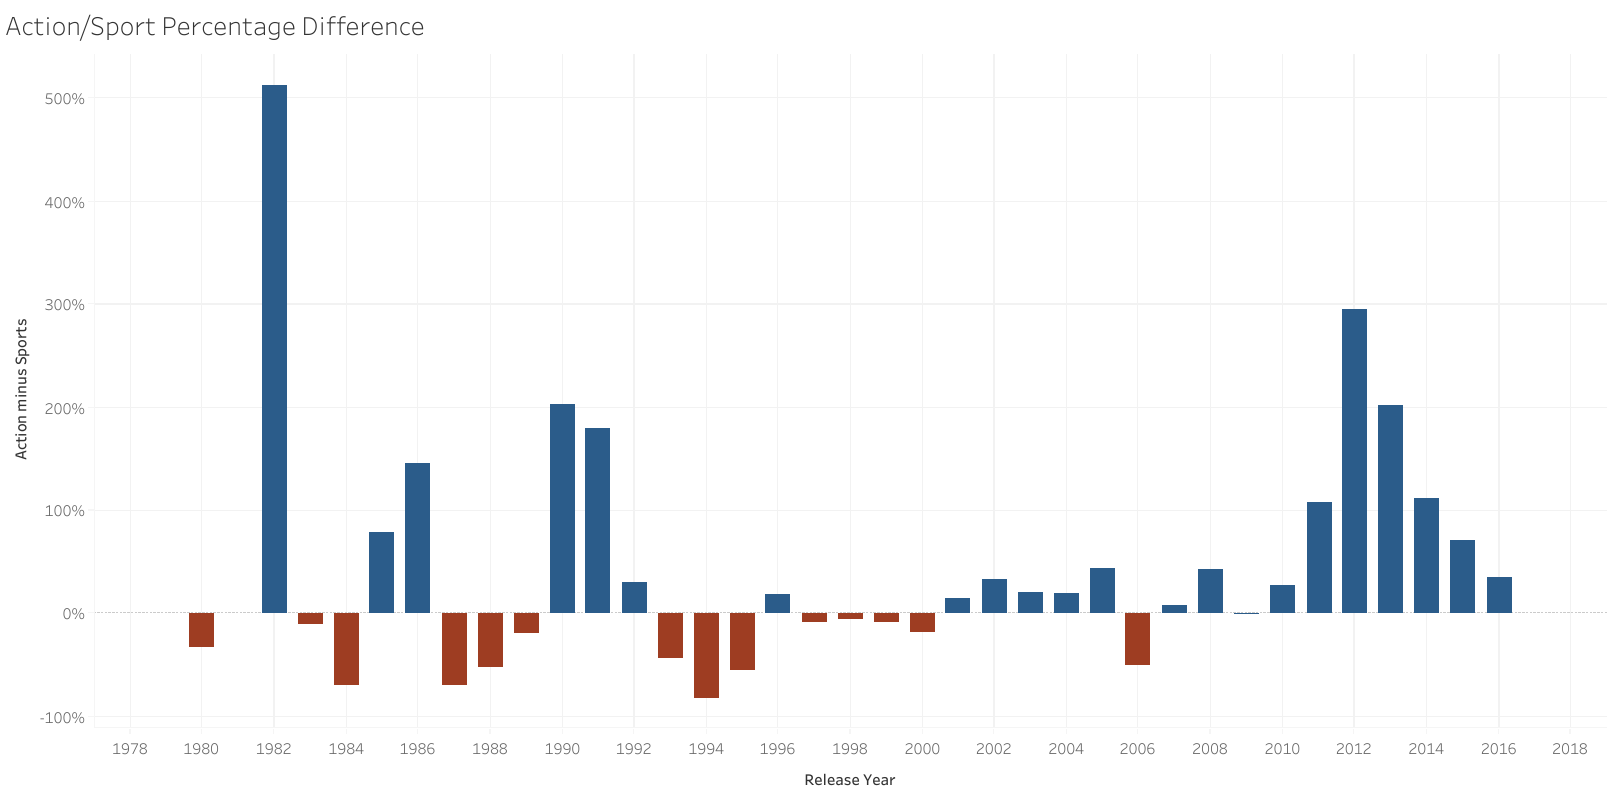

I leave out 1981 in the chart because the ratio was too high (1796%) and it makes it hard to see others small changes. Overall the 2 genres took turn to have the higher sales but after 2006 Action sales maintained relatively higher than Sports.

I want to know why the percentage in 1981 was extremely higher so this query reutrns the percentage of each genre sales during 1981. Because `GROUP BY` and aggregation are executed before window function so I can nest a `SUM` inside another `SUM` window function to compute the total sales. Sports sales only accounted for 2% of total sales, and platform genre went to top 3 with 20% sales.

In [14]:
SELECT
    genre_name,
    SUM(num_sales)*100 / SUM(SUM(num_sales)) OVER () AS pct
FROM #summary_temptbl
WHERE release_year = 1981
GROUP BY genre_name

Warning: Null value is eliminated by an aggregate or other SET operation.

(7 rows affected)

Total execution time: 00:00:00.022

genre_name,pct
Action,41.451793
Platform,19.394618
Puzzle,6.306053
Racing,1.345291
Shooter,28.082959
Simulation,1.233183
Sports,2.186098


This query shows the top 5 publishers with highest cummulative sales before 2016. It is no suprising to see Nintendo ranked first since 3/4 region outliers belong to this publisher. Other publishers are also famous companies at the moment.

In [21]:
SELECT TOP 5
    publisher_name,
    SUM(num_sales) total_sales
FROM #summary_temptbl
GROUP BY publisher_name
ORDER BY 2 DESC

Warning: Null value is eliminated by an aggregate or other SET operation.

(5 rows affected)

Total execution time: 00:00:00.107

publisher_name,total_sales
Nintendo,1784.230
Electronic Arts,1094.490
Activision,721.060
Sony Computer Entertainment,607.270
Ubisoft,473.040


I want to know how the top publishers performed since the early days of video game to 2016 so I sum the sales by `release_year` and `publisher_name`, then add `PIVOT` for report-like view. It seems that there was records for Activision sales since 1980, whereas not until 10 years later had EA and Sony had their game sold. Nitendo sales mostly stood out until 2009, then it declined and moved close with EA and Activision.

In [ ]:
SELECT * FROM
(
    SELECT
        release_year,
        publisher_name,
        num_sales as total_sales
    from #summary_temptbl
) a
PIVOT (
    sum(total_sales)
    FOR publisher_name IN (
        [Nintendo],
        [Electronic Arts],
        [Activision],
        [Sony Computer Entertainment]
    )
) AS pivot_tbl
ORDER BY 1 

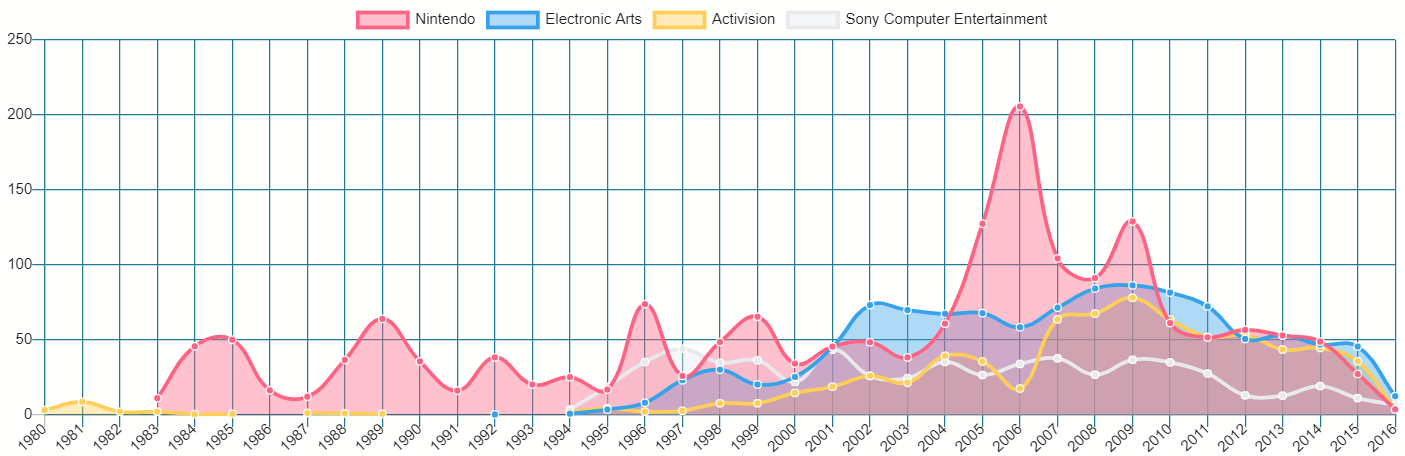

This query below add an extra window function to calculate moving average between the current year and 4 previous ones. It helps smooth out the fluctuation

In [ ]:
SELECT * FROM
(
    select
        release_year,
        publishe r_name,
        avg(total_sales) OVER (partition by publisher_name order by release_year
            rows BETWEEN 4 preceding and current row) moving_avg_5
    from 
    (
        SELECT
            release_year,
            publisher_name,
            sum(num_sales) as total_sales
        from #summary_temptbl
        WHERE publisher_name IN ('Nintendo', 'Electronic Arts', 'Activision', 'Sony Computer Entertainment')
        GROUP BY release_year, publisher_name
    ) a
) aa
PIVOT (
    sum(moving_avg_5)
    FOR publisher_name IN (
        [Nintendo],
        [Electronic Arts],
        [Activision],
        [Sony Computer Entertainment]
    )
) AS pivot_tbl
ORDER BY 1

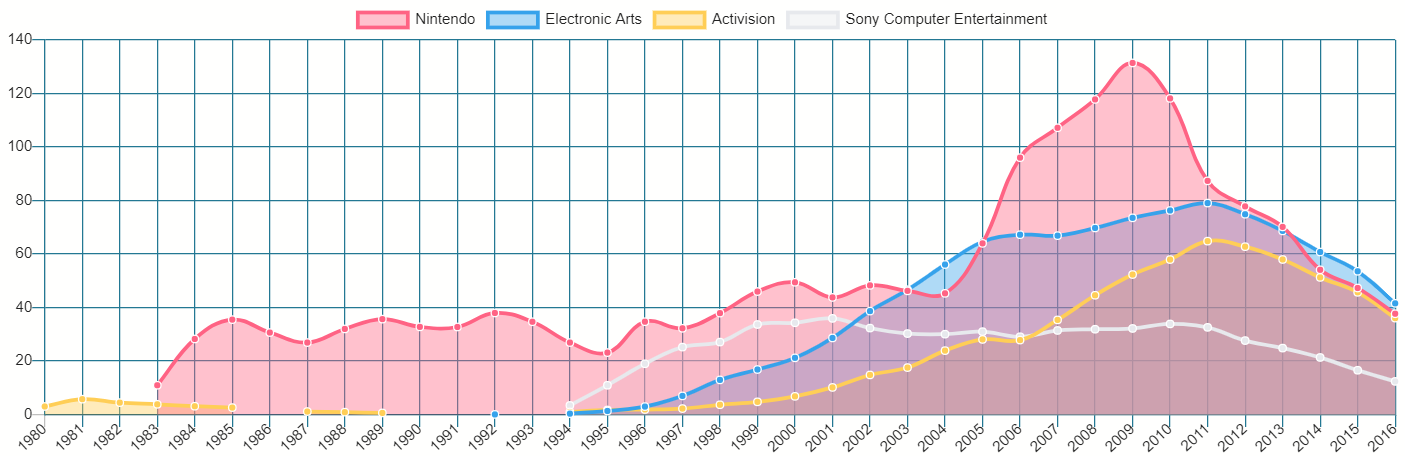

Next I move on to getting information about top platforms. At the time of getting this data, there were 2 PlayStation and 1 Xbox consoles in the top 3. Two other consoles (Wii and DS) are both made by Nintendo.

In [26]:
SELECT TOP 5
    platform_name,
    SUM(num_sales) total_sales
FROM #summary_temptbl
GROUP BY platform_name
ORDER BY 2 DESC

Warning: Null value is eliminated by an aggregate or other SET operation.

(5 rows affected)

Total execution time: 00:00:00.224

platform_name,total_sales
PS2,1233.560
X360,970.380
PS3,949.380
Wii,909.200
DS,817.650


This query presents sales from top platforms throughout the years. It's interesting that games had only been made for PS2 since 2000, and other major platforms since 2005. These platform usually hit peaks in sales after 3 to 4 years, then quickly declined. It might be that new games and remake versions of exixsting titles was made to be sold for next-gen platform. The lifespan for video games platform was pretty short.

In [ ]:
SELECT * FROM
(
    SELECT
        release_year,
        platform_name,
        num_sales as sales
    from #summary_temptbl
) a
PIVOT (
    sum(sales)
    FOR platform_name IN (
        [PS2],
        [X360],
        [PS3],
        [Wii]
    )
) AS pivot_tbl
ORDER BY 1 

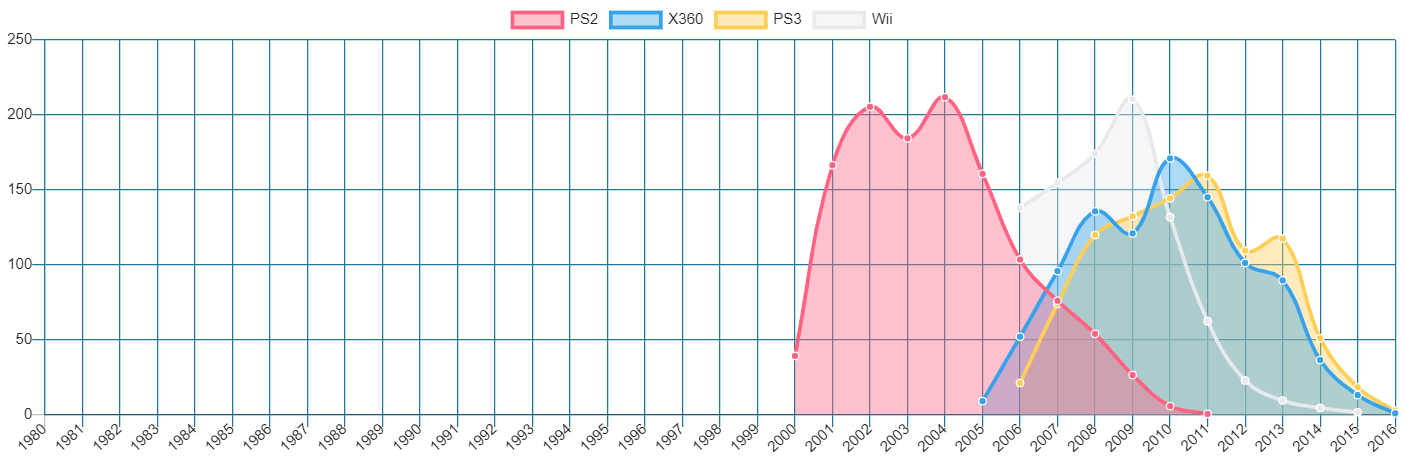


This query below is a bit complicated. I want to return a list of years and the number of platforms that has the year-in-use past those years, simply speaking, the _lifespan_ of platforms. To compute the platform lifespan, I subtract first `release_year` from the last one . Then I `CROSS JOIN` the lifespan table with a recursive CTE call `seq`. A **recursive CTE** is the one that reference itself. I use this type of CTE to generate a sequence of numbers as a single column. The `CROSS JOIN` can be used on unrelated tables by joining every rows from the 1st table with the 2nd one.

After that I will count all platforms whose lifespans exceeds the threshhold that I just cross joined and computed the final percentage. It seems that close to half of the platforms existed make it through 7 years, and the survived platforms stay flat at less than 10% after year 12.

>`OPTION(MAXRECURSION 0)` makes sure that there is no recursion limit to my CTE

In [13]:
WITH seq(n) AS (
    SELECT 0 UNION ALL SELECT n + 1 FROM seq WHERE n <= 19
)
SELECT
    b.n AS year_existed,
    COUNT(distinct case when duration >= b.n then a.platform_name end)*100 / 
        COUNT(distinct platform_name) AS cohort_survived_pct
     
FROM 
(
    SELECT
        platform_name,
        MAX(release_year) - MIN(release_year) as duration
    FROM #summary_temptbl
    GROUP BY platform_name
) a
CROSS JOIN seq b
GROUP BY b.n
ORDER BY 1
OPTION(MAXRECURSION 0)

Warning: Null value is eliminated by an aggregate or other SET operation.

(21 rows affected)

Total execution time: 00:00:00.223

year_existed,cohort_survived_pct
0,100
1,90
2,83
3,80
4,70
5,64
6,54
7,48
8,45
9,41


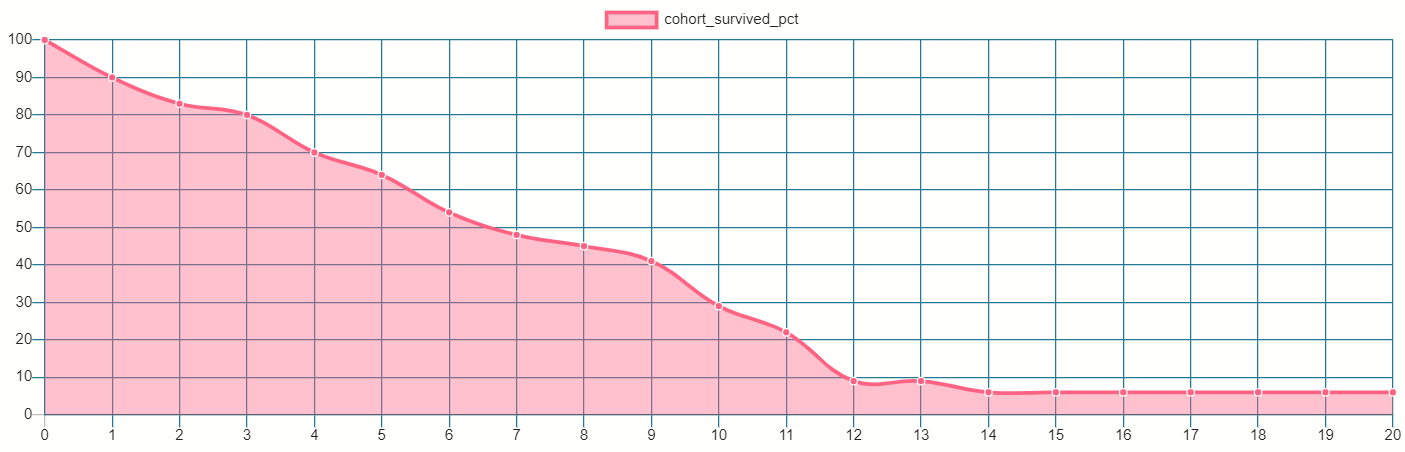


The top 10 games with greatest sales (regardless of publisher and platform) at the moment of getting data were filled with many titles from Nintendo. **Grand Theft Auto V**, an action game (open world to be more detailed) ranked second. We also have 2 **Call of Duty** shooter titles in this list.

In [12]:
SELECT TOP 10
    game_name,
    SUM(num_sales) total_sales
FROM #summary_temptbl
GROUP BY game_name
ORDER BY total_sales DESC

Warning: Null value is eliminated by an aggregate or other SET operation.

(10 rows affected)

Total execution time: 00:00:00.071

game_name,total_sales
Wii Sports,82.740
Grand Theft Auto V,55.920
Super Mario Bros.,45.310
Tetris,35.840
Mario Kart Wii,35.830
Wii Sports Resort,33.000
Pokemon Red/Pokemon Blue,31.380
Call of Duty: Modern Warfare 3,30.840
New Super Mario Bros.,30.010
Call of Duty: Black Ops II,29.730


This query tells me that, in terms of single-platform title, all Nintendo titles are in the top 5.

In [5]:
SELECT TOP 5
    game_name,
    genre_name,
    publisher_name,
    platform_name,
    SUM(num_sales) total_sales
FROM #summary_temptbl
GROUP BY game_name,
    genre_name,
    publisher_name,
    platform_name
ORDER BY total_sales DESC

Warning: Null value is eliminated by an aggregate or other SET operation.

(5 rows affected)

Total execution time: 00:00:00.528

game_name,genre_name,publisher_name,platform_name,total_sales
Wii Sports,Sports,Nintendo,Wii,82.740
Super Mario Bros.,Platform,Nintendo,NES,40.240
Mario Kart Wii,Racing,Nintendo,Wii,35.830
Wii Sports Resort,Sports,Nintendo,Wii,33.000
Pokemon Red/Pokemon Blue,Role-Playing,Nintendo,GB,31.380


I like to know more about the 2nd title with highest sales, GTA V. I concatenate the title and platforms for easy reading. This game has been released on 5 platforms from 2013 to 2015. The highest sales came with the initial release in 2013.

In [9]:
SELECT
    game_name + ' - ' + platform_name as game_platform,
    release_year,
    SUM(num_sales) sales
FROM #summary_temptbl
WHERE game_name = 'Grand Theft Auto V'
GROUP BY game_name + ' - ' + platform_name,
    release_year

Warning: Null value is eliminated by an aggregate or other SET operation.

(5 rows affected)

Total execution time: 00:00:00.033

game_platform,release_year,sales
Grand Theft Auto V - PS3,2013,21.390
Grand Theft Auto V - X360,2013,16.380
Grand Theft Auto V - PS4,2014,11.990
Grand Theft Auto V - XOne,2014,5.080
Grand Theft Auto V - PC,2015,1.080


In this query I wrapped a `CASE` statement around an aggregation for conditional calculation. The `LIKE` keyword will check if `game_name` match the pattern. Here I put `%` at the beginning and the end of the string to return all sales from titles that have similar words in their name. It is a decent way to group games from the same franchise or series together.

In [5]:
SELECT
    SUM(case when game_name LIKE '%Mario%' then num_sales END) as mario_games,
    SUM(case when game_name LIKE '%Wii%' then num_sales END) as wii_games,
    SUM(case when game_name LIKE '%Call Of Duty%' then num_sales END) as cod_games,
    SUM(case when game_name LIKE '%Pokemon%' then num_sales END) as pokemon_games,
    SUM(case when game_name LIKE '%Grand Theft Auto%' then num_sales END) as gta_games
FROM #summary_temptbl

Warning: Null value is eliminated by an aggregate or other SET operation.

(1 row affected)

Total execution time: 00:00:00.345

mario_games,wii_games,cod_games,pokemon_games,gta_games
555.280,298.340,247.650,202.440,161.620


This query shows how many publishers a game could have. It nests an aggregation from `GROUP BY` in a window function for a compact query view. Games with 2 or more publishers only accounts for around 3%. It's interesting to see titles with up to 4 publishers.

In [12]:
SELECT
    publisher,
    COUNT(publisher) as games,
    cast(COUNT(publisher) as dec(8,1))*100 / SUM(COUNT(publisher)) OVER () pct_of_total
FROM
(
    SELECT
        game_name,
        COUNT(distinct publisher_name) publisher
    FROM #summary_temptbl
    GROUP BY game_name
) a
GROUP BY publisher
ORDER BY 1 

(4 rows affected)

Total execution time: 00:00:00.066

publisher,games,pct_of_total
1,11015,96.997182106375
2,315,2.773864036632
3,21,0.184924269108
4,5,0.044029587883


### **Simple Text Analysis**

This query returns the distribution of game title's characters. Most values gather around 10 to 30 characters. We could see several extreme values on the right, from 70 to 132.

In [ ]:
SELECT
    len(game_name) game_length,
    COUNT(*) as record
FROM #summary_temptbl
GROUP BY len(game_name)
ORDER BY 1 

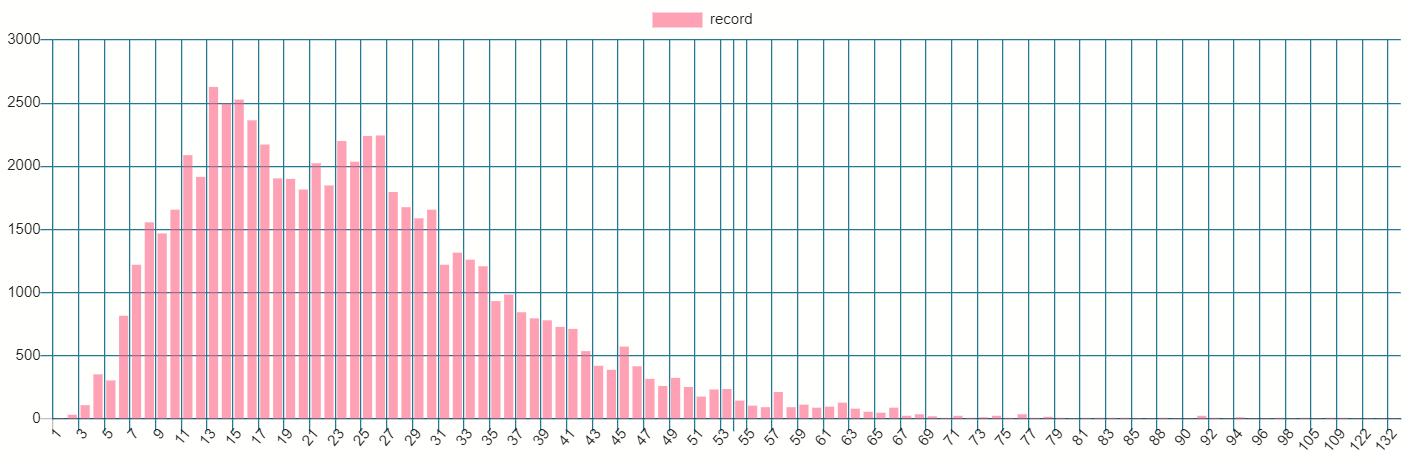

This query returns the summary statistics for the distribution of characters in game titles. Note that the average is almost equal to the median, and the distance between 1st quartile and 3rd quartile to the median is nearly the same. This might indicate that character length in game titles follows normal distribution

In [9]:
SELECT DISTINCT
    AVG(len(game_name)) OVER () as AVG_chars,
    ROUND(STDEV(len(game_name)) OVER (), 2) as std_chars,
    MIN(len(game_name)) OVER () as min_chars,
    PERCENTILE_DISC(0.25) WITHIN GROUP (ORDER BY len(game_name)) OVER () Q1_chars,
    PERCENTILE_DISC(0.5) WITHIN GROUP (ORDER BY len(game_name)) OVER () median_chars,
    PERCENTILE_DISC(0.75) WITHIN GROUP (ORDER BY len(game_name)) OVER () Q3_chars,
    MAX(len(game_name)) OVER () as max_chars
FROM #summary_temptbl

(1 row affected)

Total execution time: 00:00:01.424

AVG_chars,std_chars,min_chars,Q1_chars,median_chars,Q3_chars,max_chars
23,12.8,1,14,22,31,132


I would like to know the common number of words in a game title, so I use `COUNT` with a `CASE` condition. To returns games with only 1 word, I filtered out any titles that have a white space. For 2 words and above, I substract the title length without white spaces to the original ones.

More than 50% of games have 2 to 4 words, and a small amount of games have only 1 words.

In [31]:
SELECT
    count(distinct case when game_name NOT LIKE '% %' THEN game_name end) games_with_1_word,
    COUNT(distinct case when LEN(game_name) - LEN(REPLACE(game_name, ' ', '')) = 1 THEN game_name end) game_with_2_words,
    COUNT(distinct case when LEN(game_name) - LEN(REPLACE(game_name, ' ', '')) = 2 THEN game_name end) game_with_3_words,
    COUNT(distinct case when LEN(game_name) - LEN(REPLACE(game_name, ' ', '')) = 3 THEN game_name end) game_with_4_words,
    COUNT(distinct case when LEN(game_name) - LEN(REPLACE(game_name, ' ', '')) > 3 THEN game_name end) more_than_4_words
from #summary_temptbl

Warning: Null value is eliminated by an aggregate or other SET operation.

(1 row affected)

Total execution time: 00:00:00.387

games_with_1_word,game_with_2_words,game_with_3_words,game_with_4_words,more_than_4_words
630,2106,2641,2110,3869


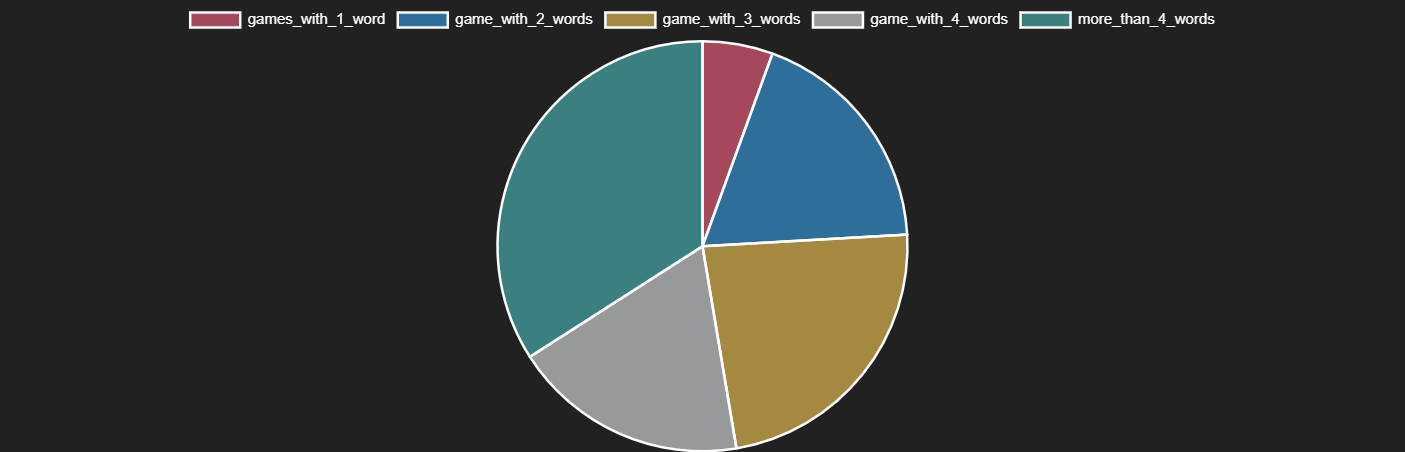

I want to know what word is used the most as the first word in game names. `LEFT` function is used to find the first word, with `CHARINDEX` return the position of the first white space. I need to add a `CASE` here because `CHARINDEX` will returns value 0 if it could not find the white space.

Besides "The", "Super" and "Dragon" are the most common first words with over 100 titles. Some first words might indicates a franchise such as "NBA", "Mario" or "Disney".

In [14]:
SELECT TOP 10
    first_word,
    COUNT(*) records
FROM
(
    SELECT
        DISTINCT game_name,
        case
            when game_name like '% %' then LEFT(game_name, CHARINDEX(' ', game_name) - 1)
            else game_name end as first_word
    from #summary_temptbl
) a
GROUP BY first_word
ORDER BY 2 DESC

(10 rows affected)

Total execution time: 00:00:00.159

first_word,records
The,415
Super,142
Dragon,107
NBA,78
World,78
Star,76
Final,63
Jikkyou,56
Monster,56
Mega,55


This file has been pretty long so I will conclude with the query that returns the most used words across all titles. First I have a CTE to store distinct game titles. then `STRING_SPLIT` function will split the strings into rows of strings based on the delimiter. `CROSS APPLY` is used when you want to split entire column instead of a single string. It ensures values will cross join with their respective game titles and the query could function properly. `VALUE` keyword represent all the split values.

I add a filter condition in the `WHERE` clause to remove words that don't have meaning. There is a `stop_words` table in the filter. **Stop words** is a set of commonly used words in a language (i.e '"a", "the", "are",...)

In the top 5 list, the number **2** and **3** are among the most used words. This could tell that there are a lot of second or third sequels to the first games. **World** and **Super** are also used a lot in games titles.

In [49]:
WITH game_name_tbl AS (
    SELECT distinct game_name
    FROM #summary_temptbl
)
select top (10) 
    VALUE as word,
    COUNT(*) as record
FROM [game_name_tbl]
CROSS APPLY STRING_SPLIT(game_name, ' ')
WHERE value NOT IN ('', '&', '-')
    AND value NOT IN 
    (
        SELECT * FROM dbo.stop_words
    )
GROUP BY [value]
ORDER BY 2 desc

(10 rows affected)

Total execution time: 00:00:00.106

word,record
2,555
World,252
3,248
2:,217
Super,215
Pro,186
Game,166
DS,164
Dragon,154
Star,144
